In [ ]:
# Cell 1: Setup & Installs (Corrected Imports)

# Install necessary libraries
!pip install -q transformers datasets peft torch scikit-learn matplotlib tqdm accelerate

# Import required modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
# --- Corrected Imports Below ---
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import LoraConfig, get_peft_model # <--- Import LoraConfig and get_peft_model from peft
# --- End Corrected Imports ---
import json
from tqdm.notebook import tqdm # Use notebook version for better Colab display
import torch.nn.functional as F
import gc
import os
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

print("Libraries installed and imported.")

# Check versions (optional)
import transformers
import peft
import datasets
print(f"Transformers version: {transformers.__version__}")
print(f"PEFT version: {peft.__version__}")
print(f"Datasets version: {datasets.__version__}")
print(f"Torch version: {torch.__version__}")

Libraries installed and imported.
Transformers version: 4.51.3
PEFT version: 0.14.0
Datasets version: 3.5.0
Torch version: 2.6.0+cu124


In [ ]:
# Cell 2: Configuration

# --- Model & Dataset Configuration ---
MODEL_NAME = "gpt2-medium"
# Path to the dataset used for Triplet Loss training
TRIPLET_DATASET_PATH = "contrastive_triplet_dataset.json"
# Path to the paired dataset used for probing evaluation
PROBING_DATASET_PATH = "smalldata.json"
# Entities used in the datasets
ENTITY_NAMES = ["Alice", "Bob", "Charlie", "David", "Eve"]

# --- LoRA Configuration ---
# (Adjust these based on previous experiments or desired setup)
LORA_R = 16             # Rank of the LoRA matrices
LORA_ALPHA = 32         # Alpha scaling factor for LoRA
LORA_DROPOUT = 0.05     # Dropout probability for LoRA layers
# Target modules for LoRA depend on the model architecture.
# For GPT-2, 'c_attn' (query, key, value projections) is common.
# You might add others like 'c_proj' (output projection) or 'c_fc' (feed-forward)
LORA_TARGET_MODULES = ['c_attn']
LORA_BIAS = "none"      # Bias type for LoRA ('none', 'all', or 'lora_only')
LORA_TASK_TYPE = "CAUSAL_LM"

# --- Triplet Loss Training Configuration ---
TARGET_LAYER = 11 # Layer index (0-based) for activation extraction (12th layer)
TARGET_HOOK_NAME = f"transformer.h.{TARGET_LAYER}.mlp.c_proj" # Hook point for MLP output
LEARNING_RATE = 1e-4
NUM_EPOCHS = 3
BATCH_SIZE = 4 # Adjust based on GPU memory (start small, e.g., 2 or 4)
TRIPLET_MARGIN = 0.5 # Margin for Triplet Loss
MAX_SEQ_LENGTH = 128 # Max sequence length for tokenizer

# --- Probing Configuration ---
# Layers/hooks to probe for evaluation (example: all MLP outputs)
# Adjust this list based on what you want to analyze
NUM_LAYERS_GPT2_MEDIUM = 24
PROBING_HOOK_POINTS = {
    # 'resid_pre_mlp_layer_{}': f'transformer.h.{{}}.ln_2', # Input to MLP (after LayerNorm)
    'mlp_out_layer_{}': f'transformer.h.{{}}.mlp.c_proj' # Output of MLP block
    # Add other points like 'resid_pre_attn', 'attn_out' if needed
}

# --- Environment Setup ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
OUTPUT_DIR = "./triplet_finetuned_adapters" # Directory to save trained adapters

print(f"Using device: {DEVICE}")
print(f"Triplet dataset path: {TRIPLET_DATASET_PATH}") #
print(f"Probing dataset path: {PROBING_DATASET_PATH}") #
print(f"Target layer for training: {TARGET_LAYER}")
print(f"Target hook name for training: {TARGET_HOOK_NAME}")
print(f"Output directory for adapters: {OUTPUT_DIR}")

Using device: cuda
Triplet dataset path: contrastive_triplet_dataset.json
Probing dataset path: smalldata.json
Target layer for training: 11
Target hook name for training: transformer.h.11.mlp.c_proj
Output directory for adapters: ./triplet_finetuned_adapters


In [ ]:
# Cell 3: Load Triplet Dataset

print(f"Loading triplet dataset from: {TRIPLET_DATASET_PATH}") #
try:
    with open(TRIPLET_DATASET_PATH, 'r') as f: #
        triplet_data = json.load(f)
    print(f"Loaded {len(triplet_data)} triplets for training.") #
except FileNotFoundError:
    print(f"Error: Triplet dataset file not found at {TRIPLET_DATASET_PATH}") #
    triplet_data = None
except json.JSONDecodeError:
    print(f"Error: Could not decode JSON from {TRIPLET_DATASET_PATH}") #
    triplet_data = None

# Optional: Quick check of the loaded data structure
if triplet_data:
    print("Triplet data structure (first item):", triplet_data[0]) #
else:
    print("Failed to load triplet data. Please check the file path and format.")
    # You might want to stop execution here if the data is essential for the next steps
    # raise ValueError("Triplet data failed to load.")

Loading triplet dataset from: contrastive_triplet_dataset.json
Loaded 2000 triplets for training.
Triplet data structure (first item): {'anchor_entity': 'Alice', 'anchor_sentence': 'In the bustling city of Tokyo, Alice navigated the corporate world, sealing a deal with a major tech firm.', 'positive_sentence': 'As dawn broke over the serene countryside in 19th-century England, Alice pondered the mysteries of a forgotten manor.', 'negative_entity': 'David', 'negative_sentence': "David meticulously adjusted his captain's hat before piloting the submarine into uncharted depths of the Arctic Ocean."}


In [ ]:
# Cell 4: Load Model & Tokenizer

from transformers import AutoTokenizer, AutoModelForCausalLM

print(f"Loading base model: {MODEL_NAME}")
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)

print(f"Loading tokenizer: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Set padding token if it's not already set
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = tokenizer.eos_token_id # Also update model config
    print("Set tokenizer pad_token to eos_token.")

print("Base model and tokenizer loaded.")
# Display model configuration (optional)
# print(model.config)
# Display tokenizer configuration (optional)
# print(tokenizer)

Loading base model: gpt2-medium


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Loading tokenizer: gpt2-medium


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Set tokenizer pad_token to eos_token.
Base model and tokenizer loaded.


In [ ]:
# Cell 5: Apply LoRA (PEFT)

from peft import LoraConfig, get_peft_model

# --- Define LoRA Configuration ---
# Uses variables defined in Cell 2 (Configuration)
peft_config = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    bias=LORA_BIAS,
    task_type=LORA_TASK_TYPE,
    target_modules=LORA_TARGET_MODULES
)

# --- Apply LoRA to the base model ---
print("Applying LoRA to the base model...")
model = get_peft_model(model, peft_config)

# --- Print Trainable Parameters ---
print("\nTrainable parameters after applying LoRA:")
model.print_trainable_parameters()

# --- Move Model to Device ---
# (Model might already be on CPU, move it to GPU if available)
print(f"\nMoving PEFT-adapted model to device: {DEVICE}...")
model.to(DEVICE)
print(f"Model is now on device: {model.device}")

# Ensure model is in training mode initially for training loop
model.train()
print("Model is set to training mode.")

Applying LoRA to the base model...

Trainable parameters after applying LoRA:
trainable params: 1,572,864 || all params: 356,396,032 || trainable%: 0.4413

Moving PEFT-adapted model to device: cuda...


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:1264: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Model is now on device: cuda:0
Model is set to training mode.


In [ ]:
# Cell 6: Corrected Triplet Loss - Dataset & DataLoader

# --- Helper Function: Find Entity Token Indices ---
# (Moved here to be available for the Dataset)
def find_entity_token_indices(input_ids_list, entity_name, tokenizer):
    """
    Finds the indices of the entity tokens within a list of token IDs.
    Handles potential prefix spaces added by the tokenizer.
    """
    # Try tokenizing with a space prefix first (common for GPT-2 BPE)
    entity_tokens_with_space = tokenizer(" " + entity_name, add_special_tokens=False).input_ids
    indices = None

    # Search for the sequence with space prefix
    for i in range(len(input_ids_list) - len(entity_tokens_with_space) + 1):
        if input_ids_list[i : i + len(entity_tokens_with_space)] == entity_tokens_with_space:
            indices = list(range(i, i + len(entity_tokens_with_space)))
            break

    # If not found, try tokenizing without the space prefix
    if indices is None:
        entity_tokens_no_space = tokenizer(entity_name, add_special_tokens=False).input_ids
        if not entity_tokens_no_space: # Handle case where entity name tokenizes to nothing
             return None
        for i in range(len(input_ids_list) - len(entity_tokens_no_space) + 1):
            if input_ids_list[i : i + len(entity_tokens_no_space)] == entity_tokens_no_space:
                indices = list(range(i, i + len(entity_tokens_no_space)))
                break

    # if indices is None:
    #    print(f"Warning: Could not find token indices for entity '{entity_name}'")

    return indices


# --- Custom Triplet Dataset (Corrected) ---
class TripletSentencesDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.data = data # Expecting the loaded list from triplet_data
        self.tokenizer = tokenizer
        self.max_length = max_length

        if not self.data:
             print("Warning: TripletSentencesDataset initialized with empty data.")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        anchor_entity = item['anchor_entity']
        negative_entity = item['negative_entity']

        # Tokenize all three sentences
        anchor_tokens = self.tokenizer(item['anchor_sentence'], max_length=self.max_length, padding="max_length", truncation=True, return_tensors=None) # Return dict of lists
        positive_tokens = self.tokenizer(item['positive_sentence'], max_length=self.max_length, padding="max_length", truncation=True, return_tensors=None)
        negative_tokens = self.tokenizer(item['negative_sentence'], max_length=self.max_length, padding="max_length", truncation=True, return_tensors=None)

        # Find entity indices within the tokenized lists
        anchor_indices = find_entity_token_indices(anchor_tokens['input_ids'], anchor_entity, self.tokenizer)
        positive_indices = find_entity_token_indices(positive_tokens['input_ids'], anchor_entity, self.tokenizer) # Same entity as anchor
        negative_indices = find_entity_token_indices(negative_tokens['input_ids'], negative_entity, self.tokenizer) # Different entity

        # Handle cases where indices weren't found (return -1 or None?)
        # Returning -1 helps keep tensor shapes consistent in collate_fn, but needs handling in the loop.
        # Need a list of indices, maybe return [-1]? Or handle filtering in collate_fn / training loop. Let's return None for now.
        # Update: Need to return *something* for collate_fn. Let's return an empty list if not found. Training loop must check for empty lists.

        return {
            "anchor_input_ids": anchor_tokens['input_ids'],
            "anchor_attention_mask": anchor_tokens['attention_mask'],
            "anchor_indices": anchor_indices if anchor_indices is not None else [],

            "positive_input_ids": positive_tokens['input_ids'],
            "positive_attention_mask": positive_tokens['attention_mask'],
            "positive_indices": positive_indices if positive_indices is not None else [],

            "negative_input_ids": negative_tokens['input_ids'],
            "negative_attention_mask": negative_tokens['attention_mask'],
            "negative_indices": negative_indices if negative_indices is not None else [],
        }

# --- Custom Collate Function ---
def triplet_collate_fn(batch):
    # Batch is a list of dictionaries from TripletSentencesDataset.__getitem__

    # Filter out items where any required indices were not found
    # It's crucial that anchor, positive, AND negative indices are valid for the triplet loss
    valid_batch = [item for item in batch if item['anchor_indices'] and item['positive_indices'] and item['negative_indices']]

    if not valid_batch:
        return None # Return None if the whole batch becomes invalid after filtering

    # Group the data by key
    collated = {}
    keys = valid_batch[0].keys()
    for key in keys:
        # Pad input_ids and attention_mask - they are already lists from tokenizer
        if key.endswith("_input_ids") or key.endswith("_attention_mask"):
             # Convert lists to tensors before padding
             tensors = [torch.tensor(item[key]) for item in valid_batch]
             collated[key] = torch.nn.utils.rnn.pad_sequence(tensors, batch_first=True, padding_value=tokenizer.pad_token_id if key.endswith("_input_ids") else 0)
        elif key.endswith("_indices"):
             # Indices are lists of variable length; keep them as a list of lists for now.
             # The training loop will need to handle this.
             collated[key] = [item[key] for item in valid_batch]
        else:
             # Should not happen with current dataset structure
             collated[key] = [item[key] for item in valid_batch]


    return collated


# --- Create Dataset & DataLoader ---
if triplet_data: # Check if data was loaded successfully in Cell 3
    print("Creating Triplet Sentences Dataset...")
    train_dataset = TripletSentencesDataset(triplet_data, tokenizer, MAX_SEQ_LENGTH)

    print("Creating DataLoader...")
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=triplet_collate_fn # Use the custom collate function
    )
    print(f"Dataset and DataLoader created. Number of items in dataset: {len(train_dataset)}") #
else:
    print("Skipping Dataset/DataLoader creation because triplet_data failed to load.")
    train_dataloader = None # Ensure variable exists but is None

# Optional: Inspect a batch from the dataloader
if train_dataloader:
    print("\nInspecting a batch from the DataLoader:")
    try:
      example_batch = next(iter(train_dataloader))
      if example_batch:
          print("Batch keys:", example_batch.keys())
          print("Anchor input_ids shape:", example_batch['anchor_input_ids'].shape)
          print("Anchor indices (first item):", example_batch['anchor_indices'][0])
          print("Positive indices (first item):", example_batch['positive_indices'][0])
          print("Negative indices (first item):", example_batch['negative_indices'][0])
      else:
          print("First batch was empty after filtering invalid items.")
    except StopIteration:
        print("DataLoader is empty.")
    except Exception as e:
        print(f"Error inspecting batch: {e}")

Creating Triplet Sentences Dataset...
Creating DataLoader...
Dataset and DataLoader created. Number of items in dataset: 2000

Inspecting a batch from the DataLoader:
Batch keys: dict_keys(['anchor_input_ids', 'anchor_attention_mask', 'anchor_indices', 'positive_input_ids', 'positive_attention_mask', 'positive_indices', 'negative_input_ids', 'negative_attention_mask', 'negative_indices'])
Anchor input_ids shape: torch.Size([4, 128])
Anchor indices (first item): [10]
Positive indices (first item): [9]
Negative indices (first item): [11]


In [ ]:
# Cell 7: Corrected Triplet Loss - Helper Functions & Hook Logic

# --- Activation Hook Logic ---
# Global dictionary to store activations during the forward pass
activations_storage = {}
# Global dictionary to store hook handles
hook_handles = {}

def get_activation_hook(layer_name):
    """Closure to create a hook function that saves activations."""
    def hook(model, input, output):
        # Output might be a tuple (e.g., for layers with past_key_values)
        # We usually want the first element which is the hidden state tensor.
        act_tensor = output[0] if isinstance(output, tuple) else output
        # Store the activation tensor itself (without detaching)
        activations_storage[layer_name] = act_tensor
    return hook

def register_hook(model, target_hook_name, layer_name_key):
    """Registers a hook for the target layer name and stores the handle."""
    global hook_handles
    module_found = False

    # Clear any previous hooks for this key to avoid duplicates
    if layer_name_key in hook_handles:
        #print(f"Removing existing hook for {layer_name_key}")
        hook_handles[layer_name_key].remove()
        del hook_handles[layer_name_key]

    # Clear previous activations for this key
    if layer_name_key in activations_storage:
        del activations_storage[layer_name_key]


    for name, module in model.named_modules():
        if name == target_hook_name:
            handle = module.register_forward_hook(get_activation_hook(layer_name_key))
            hook_handles[layer_name_key] = handle
            module_found = True
            #print(f"Registered hook for {target_hook_name} with key {layer_name_key}")
            return True

    # Try potential PEFT wrapper name if direct name fails
    potential_hook_name = f"base_model.model.{target_hook_name}"
    for name, module in model.named_modules():
         if name == potential_hook_name:
             #print(f"Registering hook for potential PEFT wrapped name: '{potential_hook_name}' using key {layer_name_key}")
             handle = module.register_forward_hook(get_activation_hook(layer_name_key))
             hook_handles[layer_name_key] = handle
             module_found = True
             return True

    print(f"Warning: Could not find module to register hook: {target_hook_name} or {potential_hook_name}")
    return False

def remove_hooks():
    """Removes all registered hooks and clears storage."""
    global hook_handles, activations_storage
    for handle in hook_handles.values():
        handle.remove()
    hook_handles = {}
    activations_storage = {} # Also clear the storage
    # print("Removed all hooks and cleared activation storage.")


# --- Activation Pooling Function ---
def pool_activations(activations_tensor, indices_list, batch_index):
    """
    Pools activations for specific token indices within a batch item.
    Args:
        activations_tensor: The tensor output by the hooked layer [batch_size, seq_len, hidden_dim].
                            Requires gradients.
        indices_list: The list of token indices corresponding to the entity for this item.
        batch_index: The index of the item within the batch.
    Returns:
        Pooled activation tensor [hidden_dim] for the entity, or None if indices are invalid.
    """
    if not indices_list: # Check if indices list is empty (entity not found)
        # print(f"Warning: Empty indices list for batch index {batch_index}. Cannot pool.")
        return None

    # Ensure indices are within the sequence length bounds
    seq_len = activations_tensor.shape[1]
    valid_indices = [idx for idx in indices_list if 0 <= idx < seq_len]

    if not valid_indices:
        # print(f"Warning: No valid indices found for batch index {batch_index} (original: {indices_list}, seq_len: {seq_len}).")
        return None

    # Select the activations for the entity tokens for the specific batch item
    # Shape: [num_entity_tokens, hidden_dim]
    entity_token_activations = activations_tensor[batch_index, valid_indices, :]

    # Pool the activations (e.g., average pooling)
    # Keep gradients flowing. Shape: [hidden_dim]
    pooled_activation = entity_token_activations.mean(dim=0)

    return pooled_activation


print("Helper functions for Dataset, DataLoader, Hooks, and Pooling defined.")

Helper functions for Dataset, DataLoader, Hooks, and Pooling defined.


Triplet Loss configured with margin=0.5 and cosine distance.
AdamW Optimizer configured. Optimizing 1572864 parameters.

Starting training for 3 epochs...


Epoch 1/3:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 1 finished. Average Loss: 0.1525


Epoch 2/3:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 2 finished. Average Loss: 0.0912


Epoch 3/3:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 3 finished. Average Loss: 0.0276

Training finished.
Final hooks removed.


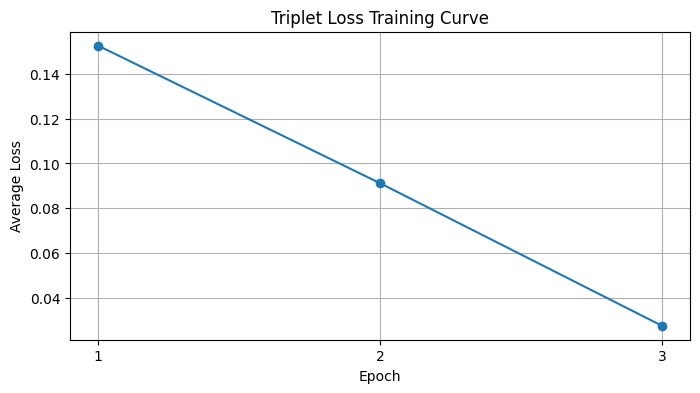


Saving trained LoRA adapters to: ./triplet_finetuned_adapters
Adapters saved.


In [ ]:
# Cell 8: Corrected Triplet Loss - Training Loop

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import gc
from tqdm.notebook import tqdm

# --- Loss Function ---
# Cosine Distance = 1 - Cosine Similarity
def cosine_distance(x1, x2, eps=1e-8):
    # Ensure inputs are Tensors before calculating similarity
    if not isinstance(x1, torch.Tensor): x1 = torch.tensor(x1, device=DEVICE)
    if not isinstance(x2, torch.Tensor): x2 = torch.tensor(x2, device=DEVICE)
    return 1.0 - F.cosine_similarity(x1, x2, dim=-1, eps=eps)

# Use standard TripletMarginLoss with our cosine distance
triplet_loss_fn = nn.TripletMarginWithDistanceLoss(
    distance_function=cosine_distance,
    margin=TRIPLET_MARGIN,
    reduction='mean' # Calculate mean loss over the batch
)
print(f"Triplet Loss configured with margin={TRIPLET_MARGIN} and cosine distance.")

# --- Optimizer ---
# Ensure only LoRA parameters are optimized
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LEARNING_RATE
)
# Verify trainable parameters again (should match output from Cell 5)
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"AdamW Optimizer configured. Optimizing {num_trainable_params} parameters.")
if num_trainable_params == 0:
    raise ValueError("No trainable parameters found. Check LoRA setup in Cell 5.")

# --- Training Prep ---
print(f"\nStarting training for {NUM_EPOCHS} epochs...")
if not train_dataloader:
     raise RuntimeError("train_dataloader is not defined. Check Cell 6 execution.")

# Ensure model is in training mode
model.train()

# List to store average loss per epoch
training_losses = []

# --- The Training Loop ---
for epoch in range(NUM_EPOCHS):
    total_epoch_loss = 0
    batches_processed = 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", leave=False)

    for batch_idx, batch in enumerate(progress_bar):

        # Check if collate_fn returned None (meaning batch was invalid)
        if batch is None:
            # print(f"Skipping empty batch {batch_idx} returned by collate_fn.")
            continue

        # Move tokenized inputs to the device
        try:
            anchor_input_ids = batch['anchor_input_ids'].to(DEVICE)
            anchor_attention_mask = batch['anchor_attention_mask'].to(DEVICE)
            positive_input_ids = batch['positive_input_ids'].to(DEVICE)
            positive_attention_mask = batch['positive_attention_mask'].to(DEVICE)
            negative_input_ids = batch['negative_input_ids'].to(DEVICE)
            negative_attention_mask = batch['negative_attention_mask'].to(DEVICE)
        except Exception as e:
            print(f"Error moving batch {batch_idx} data to device: {e}")
            continue # Skip batch if data movement fails

        # Get the corresponding lists of indices (already filtered by collate_fn)
        anchor_indices_list = batch['anchor_indices']
        positive_indices_list = batch['positive_indices']
        negative_indices_list = batch['negative_indices']

        batch_size = anchor_input_ids.size(0) # Effective batch size after filtering

        # --- Forward pass with gradient tracking ---
        optimizer.zero_grad()

        # Register the hook just before the forward pass
        remove_hooks() # Clear any lingering hooks/activations first
        if not register_hook(model, TARGET_HOOK_NAME, TARGET_HOOK_NAME):
            print(f"Error: Failed to register hook {TARGET_HOOK_NAME} in training loop. Stopping.")
            break # Stop training if hook fails

        # Forward pass for all sentences in the batch
        # We need the outputs to get activations, but don't need loss from model itself
        # The output dictionary might contain 'loss' if labels were provided, ignore it.
        # It should also contain 'hidden_states' if output_hidden_states=True was used,
        # but the hook intercepts the layer output directly.
        try:
            # Run all inputs through the model. The hook will capture the required activations.
            # Note: Running them sequentially like this is less efficient than potentially
            # batching all anchor/pos/neg together, but simpler to manage hooks.
            _ = model(input_ids=anchor_input_ids, attention_mask=anchor_attention_mask)
            anchor_activations_tensor = activations_storage.get(TARGET_HOOK_NAME) # Get activations captured by hook
            if anchor_activations_tensor is None: raise RuntimeError(f"Hook failed to capture anchor activations for {TARGET_HOOK_NAME}")
            activations_storage.clear() # Clear storage for next pass

            _ = model(input_ids=positive_input_ids, attention_mask=positive_attention_mask)
            positive_activations_tensor = activations_storage.get(TARGET_HOOK_NAME)
            if positive_activations_tensor is None: raise RuntimeError(f"Hook failed to capture positive activations for {TARGET_HOOK_NAME}")
            activations_storage.clear()

            _ = model(input_ids=negative_input_ids, attention_mask=negative_attention_mask)
            negative_activations_tensor = activations_storage.get(TARGET_HOOK_NAME)
            if negative_activations_tensor is None: raise RuntimeError(f"Hook failed to capture negative activations for {TARGET_HOOK_NAME}")
            activations_storage.clear()

        except Exception as e:
            print(f"Error during model forward pass in batch {batch_idx}: {e}")
            remove_hooks() # Clean up hook
            continue # Skip this batch

        # Remove the hook now that forward passes are done
        remove_hooks()

        # --- Pool Activations for Entities ---
        # Store pooled activations for items that succeed
        valid_anchor_pooled = []
        valid_positive_pooled = []
        valid_negative_pooled = []

        for i in range(batch_size): # Iterate through items in the batch
            anchor_pooled = pool_activations(anchor_activations_tensor, anchor_indices_list[i], i)
            positive_pooled = pool_activations(positive_activations_tensor, positive_indices_list[i], i)
            negative_pooled = pool_activations(negative_activations_tensor, negative_indices_list[i], i)

            # Only keep triplets where all pooling succeeded
            if anchor_pooled is not None and positive_pooled is not None and negative_pooled is not None:
                valid_anchor_pooled.append(anchor_pooled)
                valid_positive_pooled.append(positive_pooled)
                valid_negative_pooled.append(negative_pooled)
            # else:
            #    print(f"Skipping item {i} in batch {batch_idx} due to pooling failure.")


        # --- Calculate Loss and Backpropagate ---
        if not valid_anchor_pooled:
            # print(f"Skipping batch {batch_idx} as no valid pooled triplets remained.")
            continue # Skip if the entire batch failed pooling

        # Stack the valid pooled activations into tensors for the loss function
        # Shapes: [effective_batch_size, hidden_dim]
        anchor_batch_pooled = torch.stack(valid_anchor_pooled)
        positive_batch_pooled = torch.stack(valid_positive_pooled)
        negative_batch_pooled = torch.stack(valid_negative_pooled)

        # Calculate the triplet loss
        loss = triplet_loss_fn(anchor_batch_pooled, positive_batch_pooled, negative_batch_pooled)

        # Backward pass (calculates gradients for LoRA params)
        loss.backward()

        # Optimizer step (updates LoRA params)
        optimizer.step()

        # --- Logging and Cleanup ---
        batch_loss = loss.item()
        total_epoch_loss += batch_loss
        batches_processed += 1
        progress_bar.set_postfix({'loss': batch_loss})

        # Optional: Clear CUDA cache periodically for very large models/batches
        if batch_idx % 50 == 0: # Adjust frequency as needed
            gc.collect()
            torch.cuda.empty_cache()

    # --- End of Epoch ---
    if batches_processed > 0:
        avg_epoch_loss = total_epoch_loss / batches_processed
        training_losses.append(avg_epoch_loss)
        print(f"\nEpoch {epoch+1} finished. Average Loss: {avg_epoch_loss:.4f}")
    else:
        print(f"\nEpoch {epoch+1} finished. No batches processed successfully.")
        training_losses.append(None) # Indicate epoch had no valid batches

# --- End of Training ---
print("\nTraining finished.")

# Clean up hooks after training completes
remove_hooks()
print("Final hooks removed.")

# --- Plot Training Loss ---
valid_losses = [loss for loss in training_losses if loss is not None]
if valid_losses:
   epochs_with_losses = [i+1 for i, loss in enumerate(training_losses) if loss is not None]
   plt.figure(figsize=(8, 4))
   plt.plot(epochs_with_losses, valid_losses, marker='o')
   plt.xlabel("Epoch")
   plt.ylabel("Average Loss")
   plt.title("Triplet Loss Training Curve")
   plt.xticks(epochs_with_losses) # Ensure ticks match epochs with data
   plt.grid(True)
   plt.show()
else:
    print("No valid epoch losses recorded to plot.")

# --- Save Adapters ---
print(f"\nSaving trained LoRA adapters to: {OUTPUT_DIR}")
os.makedirs(OUTPUT_DIR, exist_ok=True)
model.save_pretrained(OUTPUT_DIR)
# You might also want to save the tokenizer configuration if needed, though it wasn't fine-tuned
# tokenizer.save_pretrained(OUTPUT_DIR)
print("Adapters saved.")

In [ ]:
# Cell 9: Load Probing Dataset

import json

print(f"Loading probing dataset from: {PROBING_DATASET_PATH}") # Using path defined in Cell 2, points to smalldata.json
probing_data = []
try:
    with open(PROBING_DATASET_PATH, 'r') as f: #
        probing_data = json.load(f) #
    print(f"Loaded {len(probing_data)} pairs for probing.") #
except FileNotFoundError:
    print(f"Error: Probing dataset file not found at {PROBING_DATASET_PATH}") #
    # Handle error appropriately, maybe stop execution
    raise
except json.JSONDecodeError:
    print(f"Error: Could not decode JSON from {PROBING_DATASET_PATH}") #
    # Handle error appropriately
    raise

# Optional: Quick check of the loaded data structure
if probing_data:
    print("Probing data structure (first item):", probing_data[0]) #

Loading probing dataset from: smalldata.json
Loaded 80 pairs for probing.
Probing data structure (first item): {'entity': 'Alice', 'sentence_a': 'After the thunderstorm, Alice helped clean up fallen branches in the backyard.', 'sentence_b': 'At dawn, Alice meditated quietly beside a mountain lake.'}


In [ ]:
# Cell 10: Probing Setup (Load Model, Hooks, Activation Extraction)

from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel # Use PeftModel to load adapters
import torch
import gc
from collections import defaultdict

# --- Function to Load Model with Trained Adapters ---
def load_trained_model(base_model_name, adapter_path, device):
    """Loads the base model and applies the saved LoRA adapters."""
    print(f"Loading base model: {base_model_name}")
    model = AutoModelForCausalLM.from_pretrained(base_model_name)

    print(f"Loading trained LoRA adapters from: {adapter_path}")
    # Ensure the adapter path exists
    if not os.path.isdir(adapter_path):
         raise FileNotFoundError(f"Adapter directory not found: {adapter_path}. Ensure Cell 8 ran successfully and saved adapters.")

    # Load the LoRA adapters onto the base model
    try:
      model = PeftModel.from_pretrained(model, adapter_path)
      print("Successfully loaded LoRA adapters.")
    except Exception as e:
      print(f"Error loading PEFT model from {adapter_path}: {e}")
      print("Ensure the path is correct and contains adapter_config.json, adapter_model.bin etc.")
      raise

    model.eval()  # Set model to evaluation mode for probing
    model.to(device)
    print(f"Trained model loaded and moved to {device}. Set to eval mode.")
    return model

# --- Reload Tokenizer (or reuse from Cell 4) ---
# Ensure tokenizer matches the one used during training/loading
# Reusing tokenizer loaded in Cell 4 should be fine if notebook session is continuous
# tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
# if tokenizer.pad_token is None:
#     tokenizer.pad_token = tokenizer.eos_token
print(f"Using tokenizer loaded previously for {MODEL_NAME}.")


# --- Re-define Hook Logic (Similar to Cell 7, maybe make it a class later if needed) ---
probing_activations_storage = {}
probing_hook_handles = {}

def get_probing_activation_hook(layer_name):
    def hook(model, input, output):
        act_tensor = output[0] if isinstance(output, tuple) else output
        probing_activations_storage[layer_name] = act_tensor.detach().cpu() # Detach and move to CPU for storage
    return hook

def register_probing_hook(model, target_hook_name, layer_name_key):
    global probing_hook_handles
    module_found = False
    # Clear previous hook for this key
    if layer_name_key in probing_hook_handles:
        probing_hook_handles[layer_name_key].remove()
    for name, module in model.named_modules():
        if name == target_hook_name:
            handle = module.register_forward_hook(get_probing_activation_hook(layer_name_key))
            probing_hook_handles[layer_name_key] = handle
            return True
    # Check PEFT wrapped name (less likely needed after merging, but safe check)
    potential_hook_name = f"base_model.model.{target_hook_name}"
    for name, module in model.named_modules():
         if name == potential_hook_name:
             handle = module.register_forward_hook(get_probing_activation_hook(layer_name_key))
             probing_hook_handles[layer_name_key] = handle
             return True
    # Check if the model was potentially merged
    potential_merged_hook_name = target_hook_name # If merged, name might be direct
    for name, module in model.named_modules():
         if name == potential_merged_hook_name:
             handle = module.register_forward_hook(get_probing_activation_hook(layer_name_key))
             probing_hook_handles[layer_name_key] = handle
             return True

    print(f"Warning: Could not find module for probing hook: {target_hook_name} or potential alternatives.")
    return False

def remove_probing_hooks():
    global probing_hook_handles, probing_activations_storage
    for handle in probing_hook_handles.values():
        handle.remove()
    probing_hook_handles = {}
    probing_activations_storage = {}

# --- Re-define find_entity_token_indices (same as Cell 6) ---
# (Ensure it's available here or imported)
# def find_entity_token_indices(input_ids_list, entity_name, tokenizer): ... (copy from Cell 6 if needed)


# --- Activation Extraction Function for Probing ---
def extract_activations_for_probing(model, tokenizer, data, hook_point_template, layer_indices, entity_filter=None, sentence_key='sentence_a'):
    """
    Extracts activations for specified entities and layers using hooks.

    Args:
        model: The loaded model (with adapters).
        tokenizer: The tokenizer.
        data: The list of dictionaries loaded from the probing dataset (smalldata.json).
        hook_point_template: String template for hook names (e.g., 'transformer.h.{}.mlp.c_proj').
        layer_indices: List of layer indices to probe.
        entity_filter (list, optional): List of entity names to extract. If None, uses all found.
        sentence_key (str): Which sentence to use ('sentence_a' or 'sentence_b').

    Returns:
        Dictionary mapping hook_name -> entity -> list of activation vectors (numpy arrays).
    """
    model.eval() # Ensure model is in eval mode
    activations_by_hook = defaultdict(lambda: defaultdict(list))
    max_len = MAX_SEQ_LENGTH # Use config from Cell 2

    # Determine target entities
    if entity_filter:
        target_entities = set(entity_filter)
    else:
        target_entities = set(item['entity'] for item in data) #

    print(f"Extracting activations for entities: {target_entities}, sentence key: '{sentence_key}'")

    # Register all hooks needed first
    hook_registered_successfully = {}
    for layer_idx in layer_indices:
        hook_name = hook_point_template.format(layer_idx)
        hook_key = f"layer_{layer_idx}" # Unique key for storage/handles per layer
        hook_registered_successfully[hook_key] = register_probing_hook(model, hook_name, hook_key)
        if not hook_registered_successfully[hook_key]:
             print(f"Skipping layer {layer_idx} due to hook registration failure.")

    # Prepare lists of hook keys and names that were successful
    successful_hook_keys = [key for key, success in hook_registered_successfully.items() if success]
    successful_hook_names = {key: hook_point_template.format(int(key.split('_')[-1])) for key in successful_hook_keys}


    if not successful_hook_keys:
        print("Error: No hooks registered successfully. Cannot extract activations.")
        remove_probing_hooks()
        return {}

    # Process data
    with torch.no_grad():
        for item in tqdm(data, desc="Extracting Activations"): #
            entity = item['entity'] #
            if entity not in target_entities:
                continue

            sentence = item[sentence_key] #
            tokenized = tokenizer(sentence, max_length=max_len, padding="max_length", truncation=True, return_tensors="pt").to(DEVICE)
            input_ids_list = tokenized['input_ids'].squeeze().tolist()

            # Find entity indices
            indices = find_entity_token_indices(input_ids_list, entity, tokenizer)
            if not indices:
                # print(f"Warning: Could not find indices for '{entity}' in '{sentence[:50]}...'. Skipping item.")
                continue

            # Run forward pass - hooks capture activations
            _ = model(**tokenized)

            # Extract and pool activations for this item from all successful hooks
            for hook_key in successful_hook_keys:
                layer_activations = probing_activations_storage.get(hook_key)
                if layer_activations is None:
                    # print(f"Warning: Activations not found for hook {hook_key} for item with entity {entity}. Skipping.")
                    continue

                # Pooling (use mean pooling here)
                seq_len = layer_activations.shape[1]
                valid_indices = [idx for idx in indices if 0 <= idx < seq_len]
                if not valid_indices:
                    continue

                # Activations are already on CPU from hook
                entity_token_activations = layer_activations[0, valid_indices, :] # [num_tokens, hidden_dim]
                pooled_activation = entity_token_activations.mean(dim=0).numpy() # Pool and convert to numpy array

                hook_display_name = successful_hook_names[hook_key] # Get the actual layer name for storage key
                activations_by_hook[hook_display_name][entity].append(pooled_activation)

            # Clear storage for next item (hooks remain registered)
            probing_activations_storage.clear()


    # Remove hooks once done with all data
    remove_probing_hooks()
    print("Finished extraction. Hooks removed.")

    # Clean up memory
    gc.collect()
    torch.cuda.empty_cache()

    return dict(activations_by_hook) # Convert back to regular dict

# --- Load the Trained Model ---
# Uses OUTPUT_DIR defined in Cell 2
trained_model = load_trained_model(MODEL_NAME, OUTPUT_DIR, DEVICE)

print("\nProbing setup complete. Model loaded with trained adapters.")

Using tokenizer loaded previously for gpt2-medium.
Loading base model: gpt2-medium
Loading trained LoRA adapters from: ./triplet_finetuned_adapters
Successfully loaded LoRA adapters.
Trained model loaded and moved to cuda. Set to eval mode.

Probing setup complete. Model loaded with trained adapters.


In [ ]:
# Cell 11: Probing - Entity Discrimination Task (Activation Extraction Part)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import numpy as np

# --- Configuration for this Task ---
ENTITY_A = "Alice" # Choose first entity
ENTITY_B = "Bob"   # Choose second entity
LAYERS_TO_PROBE = list(range(NUM_LAYERS_GPT2_MEDIUM)) # Probe all layers defined in config (e.g., 0-23 for gpt2-medium)
HOOK_TEMPLATE = 'transformer.h.{}.mlp.c_proj' # Use MLP output for this example (matches PROBING_HOOK_POINTS key pattern)

print(f"--- Starting Entity Discrimination Probing ---")
print(f"Comparing: {ENTITY_A} vs {ENTITY_B}")
print(f"Probing layers: {LAYERS_TO_PROBE}")
print(f"Using hook template: {HOOK_TEMPLATE}")

# --- Extract Activations ---
# Use sentence_a from the probing data for both entities
# We need activations for Alice AND Bob from the same set of sentences/contexts ideally,
# but smalldata.json pairs them. Let's extract from sentence_a for simplicity first.
# A more rigorous approach might balance contexts, but this tests basic separability.

print(f"\nExtracting activations for {ENTITY_A}...")
activations_entity_A = extract_activations_for_probing(
    model=trained_model,
    tokenizer=tokenizer,
    data=probing_data, #
    hook_point_template=HOOK_TEMPLATE,
    layer_indices=LAYERS_TO_PROBE,
    entity_filter=[ENTITY_A],
    sentence_key='sentence_a'
)

print(f"\nExtracting activations for {ENTITY_B}...")
activations_entity_B = extract_activations_for_probing(
    model=trained_model,
    tokenizer=tokenizer,
    data=probing_data, #
    hook_point_template=HOOK_TEMPLATE,
    layer_indices=LAYERS_TO_PROBE,
    entity_filter=[ENTITY_B],
    sentence_key='sentence_a' # Use same sentence key for comparability
)

print("\nActivation extraction for Entity Discrimination task complete.")

# --- Data Check (Optional) ---
# Check if activations were extracted for all layers/entities
if activations_entity_A and activations_entity_B:
    example_layer_hook = HOOK_TEMPLATE.format(LAYERS_TO_PROBE[0]) # Check first layer
    print(f"\nExample: Activations for {ENTITY_A} at {example_layer_hook}: Found {len(activations_entity_A.get(example_layer_hook, {}).get(ENTITY_A, []))} samples.")
    print(f"Example: Activations for {ENTITY_B} at {example_layer_hook}: Found {len(activations_entity_B.get(example_layer_hook, {}).get(ENTITY_B, []))} samples.")
    if activations_entity_A.get(example_layer_hook, {}).get(ENTITY_A):
       print(f"Shape of first activation vector for {ENTITY_A}: {activations_entity_A[example_layer_hook][ENTITY_A][0].shape}")
else:
    print("\nWarning: Activation extraction might have failed for one or both entities.")

# --- (Probe Training/Evaluation will go in the next part of Cell 12) ---

--- Starting Entity Discrimination Probing ---
Comparing: Alice vs Bob
Probing layers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
Using hook template: transformer.h.{}.mlp.c_proj

Extracting activations for Alice...
Extracting activations for entities: {'Alice'}, sentence key: 'sentence_a'


Extracting Activations:   0%|          | 0/80 [00:00<?, ?it/s]

Finished extraction. Hooks removed.

Extracting activations for Bob...
Extracting activations for entities: {'Bob'}, sentence key: 'sentence_a'


Extracting Activations:   0%|          | 0/80 [00:00<?, ?it/s]

Finished extraction. Hooks removed.

Activation extraction for Entity Discrimination task complete.

Example: Activations for Alice at transformer.h.0.mlp.c_proj: Found 16 samples.
Example: Activations for Bob at transformer.h.0.mlp.c_proj: Found 16 samples.
Shape of first activation vector for Alice: (1024,)



--- Training Probes for Entity Discrimination (Alice vs Bob) ---

--- Entity Discrimination AUC Scores ---
                        Hook Point  Entity AUC
Layer                                         
0       transformer.h.0.mlp.c_proj         1.0
1       transformer.h.1.mlp.c_proj         1.0
2       transformer.h.2.mlp.c_proj         1.0
3       transformer.h.3.mlp.c_proj         1.0
4       transformer.h.4.mlp.c_proj         1.0
5       transformer.h.5.mlp.c_proj         1.0
6       transformer.h.6.mlp.c_proj         1.0
7       transformer.h.7.mlp.c_proj         1.0
8       transformer.h.8.mlp.c_proj         1.0
9       transformer.h.9.mlp.c_proj         1.0
10     transformer.h.10.mlp.c_proj         1.0
11     transformer.h.11.mlp.c_proj         1.0
12     transformer.h.12.mlp.c_proj         1.0
13     transformer.h.13.mlp.c_proj         1.0
14     transformer.h.14.mlp.c_proj         1.0
15     transformer.h.15.mlp.c_proj         1.0
16     transformer.h.16.mlp.c_proj         1.0

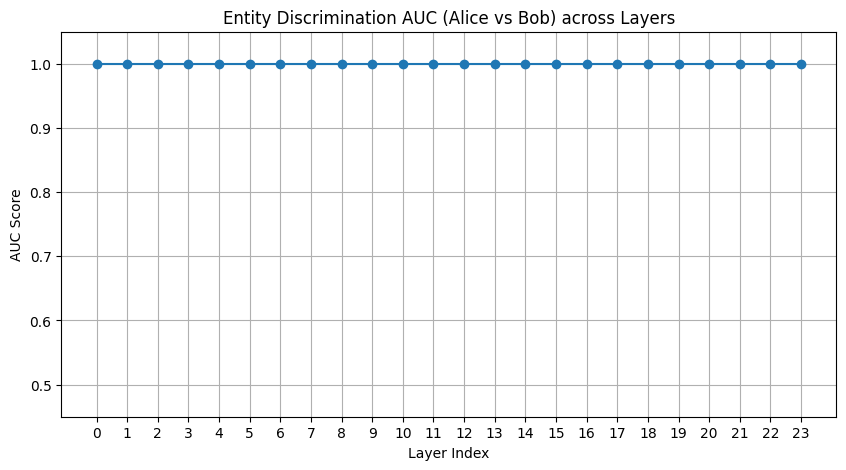

In [ ]:
# Cell 12: Probe Training & Evaluation

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd # Optional: for better display of results

# --- Train Probes and Calculate AUC ---
entity_auc_scores = {}

print(f"\n--- Training Probes for Entity Discrimination ({ENTITY_A} vs {ENTITY_B}) ---")

for layer_idx in LAYERS_TO_PROBE:
    hook_name = HOOK_TEMPLATE.format(layer_idx)

    # Check if activations exist for this hook for both entities
    activ_A = activations_entity_A.get(hook_name, {}).get(ENTITY_A, [])
    activ_B = activations_entity_B.get(hook_name, {}).get(ENTITY_B, [])

    if not activ_A or not activ_B:
        print(f"Skipping {hook_name}: Insufficient activation data (A:{len(activ_A)}, B:{len(activ_B)}).")
        entity_auc_scores[hook_name] = np.nan # Record NaN if data is missing
        continue

    # Prepare data for scikit-learn
    X = np.array(activ_A + activ_B)
    y = np.array([0] * len(activ_A) + [1] * len(activ_B)) # 0 for Entity A, 1 for Entity B

    # Ensure we have enough samples and variance
    if len(np.unique(y)) < 2:
         print(f"Skipping {hook_name}: Only one class present after preparing data.")
         entity_auc_scores[hook_name] = np.nan
         continue
    if X.shape[0] < 4: # Need at least a few samples for train/test split
         print(f"Skipping {hook_name}: Not enough total samples ({X.shape[0]}).")
         entity_auc_scores[hook_name] = np.nan
         continue


    # Split data (stratified if possible, though balanced here)
    try:
      X_train, X_test, y_train, y_test = train_test_split(
          X, y, test_size=0.3, random_state=42, stratify=y
      )
    except ValueError:
        # Fallback if stratification fails (e.g., too few samples per class in split)
        print(f"Warning: Stratification failed for {hook_name}, using non-stratified split.")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42
        )


    # Train a simple linear probe (Logistic Regression)
    # Increase max_iter if convergence warnings appear
    probe = LogisticRegression(solver='liblinear', random_state=42, max_iter=1000)
    try:
        probe.fit(X_train, y_train)

        # Evaluate using AUC
        # Predict probabilities for the positive class (Entity B)
        y_pred_proba = probe.predict_proba(X_test)[:, 1]
        auc_score = roc_auc_score(y_test, y_pred_proba)
        entity_auc_scores[hook_name] = auc_score
        # print(f"Probe trained for {hook_name}. AUC: {auc_score:.4f}") # Optional: print AUC per layer

    except Exception as e:
        print(f"Error training or evaluating probe for {hook_name}: {e}")
        entity_auc_scores[hook_name] = np.nan


# --- Display Results ---
print("\n--- Entity Discrimination AUC Scores ---")
# Optional: Use pandas for nicer formatting
try:
    entity_results_df = pd.DataFrame(list(entity_auc_scores.items()), columns=['Hook Point', 'Entity AUC'])
    entity_results_df['Layer'] = entity_results_df['Hook Point'].apply(lambda x: int(x.split('.')[2]))
    entity_results_df = entity_results_df.sort_values('Layer').set_index('Layer')
    print(entity_results_df)
except ImportError:
    # Fallback if pandas is not available
    print("Hook Point\t\tEntity AUC")
    for hook, score in sorted(entity_auc_scores.items(), key=lambda item: int(item[0].split('.')[2])):
         print(f"{hook}\t{score:.4f}")

# Optional: Plot the results
plt.figure(figsize=(10, 5))
plt.plot(entity_results_df.index, entity_results_df['Entity AUC'], marker='o')
plt.title(f'Entity Discrimination AUC ({ENTITY_A} vs {ENTITY_B}) across Layers')
plt.xlabel('Layer Index')
plt.ylabel('AUC Score')
plt.xticks(entity_results_df.index)
plt.ylim(0.45, 1.05) # Adjust ylim if needed
plt.grid(True)
plt.show()

--- Starting Context Discrimination Probing ---
Testing invariance for entity: Alice
Probing layers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
Using hook template: transformer.h.{}.mlp.c_proj

Extracting activations for Alice in context 'a'...
Extracting activations for entities: {'Alice'}, sentence key: 'sentence_a'


Extracting Activations:   0%|          | 0/80 [00:00<?, ?it/s]

Finished extraction. Hooks removed.

Extracting activations for Alice in context 'b'...
Extracting activations for entities: {'Alice'}, sentence key: 'sentence_b'


Extracting Activations:   0%|          | 0/80 [00:00<?, ?it/s]

Finished extraction. Hooks removed.

Activation extraction for Context Discrimination task complete.

Example: Activations for Alice (Context A) at transformer.h.0.mlp.c_proj: Found 16 samples.
Example: Activations for Alice (Context B) at transformer.h.0.mlp.c_proj: Found 16 samples.
Shape of first activation vector for Alice (Context A): (1024,)

--- Training Probes for Context Discrimination (Alice: Context A vs B) ---

--- Context Discrimination AUC Scores ---
                        Hook Point  Context AUC
Layer                                          
0       transformer.h.0.mlp.c_proj          1.0
1       transformer.h.1.mlp.c_proj          1.0
2       transformer.h.2.mlp.c_proj          1.0
3       transformer.h.3.mlp.c_proj          1.0
4       transformer.h.4.mlp.c_proj          1.0
5       transformer.h.5.mlp.c_proj          1.0
6       transformer.h.6.mlp.c_proj          1.0
7       transformer.h.7.mlp.c_proj          1.0
8       transformer.h.8.mlp.c_proj          1.0
9  

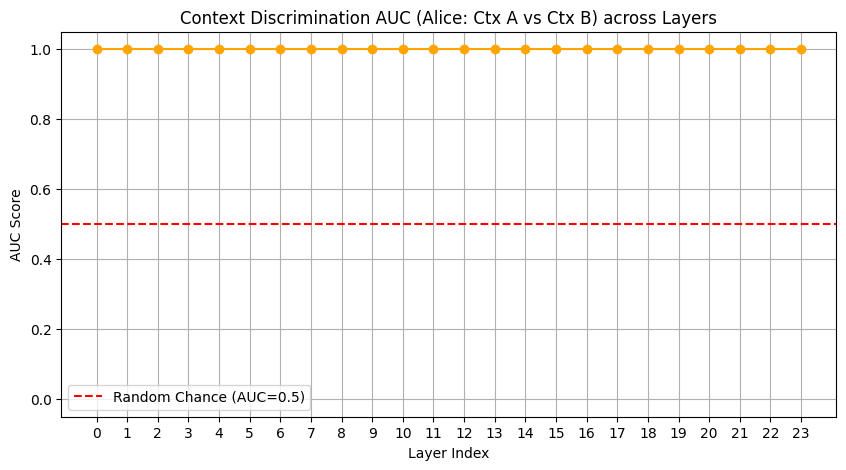

In [ ]:
# Cell 13: Probing - Context Discrimination Task

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# --- Configuration for this Task ---
CONTEXT_ENTITY = "Alice" # Choose the entity to test context invariance for
# Use the same layers and hook template as the entity task for comparison
LAYERS_TO_PROBE = list(range(NUM_LAYERS_GPT2_MEDIUM))
HOOK_TEMPLATE = 'transformer.h.{}.mlp.c_proj'

print(f"--- Starting Context Discrimination Probing ---")
print(f"Testing invariance for entity: {CONTEXT_ENTITY}")
print(f"Probing layers: {LAYERS_TO_PROBE}")
print(f"Using hook template: {HOOK_TEMPLATE}")

# --- Extract Activations for Both Contexts ---

print(f"\nExtracting activations for {CONTEXT_ENTITY} in context 'a'...")
activations_context_A = extract_activations_for_probing(
    model=trained_model, # Model loaded in Cell 10 (user's numbering)
    tokenizer=tokenizer,
    data=probing_data, # Data loaded in Cell 9 (user's numbering)
    hook_point_template=HOOK_TEMPLATE,
    layer_indices=LAYERS_TO_PROBE,
    entity_filter=[CONTEXT_ENTITY],
    sentence_key='sentence_a' # Use sentence_a
)

print(f"\nExtracting activations for {CONTEXT_ENTITY} in context 'b'...")
activations_context_B = extract_activations_for_probing(
    model=trained_model,
    tokenizer=tokenizer,
    data=probing_data, #
    hook_point_template=HOOK_TEMPLATE,
    layer_indices=LAYERS_TO_PROBE,
    entity_filter=[CONTEXT_ENTITY],
    sentence_key='sentence_b' # Use sentence_b
)

print("\nActivation extraction for Context Discrimination task complete.")

# --- Data Check (Optional) ---
if activations_context_A and activations_context_B:
    example_layer_hook = HOOK_TEMPLATE.format(LAYERS_TO_PROBE[0]) # Check first layer
    print(f"\nExample: Activations for {CONTEXT_ENTITY} (Context A) at {example_layer_hook}: Found {len(activations_context_A.get(example_layer_hook, {}).get(CONTEXT_ENTITY, []))} samples.")
    print(f"Example: Activations for {CONTEXT_ENTITY} (Context B) at {example_layer_hook}: Found {len(activations_context_B.get(example_layer_hook, {}).get(CONTEXT_ENTITY, []))} samples.")
    if activations_context_A.get(example_layer_hook, {}).get(CONTEXT_ENTITY):
       print(f"Shape of first activation vector for {CONTEXT_ENTITY} (Context A): {activations_context_A[example_layer_hook][CONTEXT_ENTITY][0].shape}")
else:
    print("\nWarning: Activation extraction might have failed for one or both contexts.")


# --- Train Probes and Calculate AUC ---
context_auc_scores = {}

print(f"\n--- Training Probes for Context Discrimination ({CONTEXT_ENTITY}: Context A vs B) ---")

for layer_idx in LAYERS_TO_PROBE:
    hook_name = HOOK_TEMPLATE.format(layer_idx)

    # Get activations for context A and B for the current layer
    activ_ctx_A = activations_context_A.get(hook_name, {}).get(CONTEXT_ENTITY, [])
    activ_ctx_B = activations_context_B.get(hook_name, {}).get(CONTEXT_ENTITY, [])

    if not activ_ctx_A or not activ_ctx_B:
        print(f"Skipping {hook_name}: Insufficient activation data (Ctx A:{len(activ_ctx_A)}, Ctx B:{len(activ_ctx_B)}).")
        context_auc_scores[hook_name] = np.nan # Record NaN
        continue

    # Prepare data: 0 for context A, 1 for context B
    X = np.array(activ_ctx_A + activ_ctx_B)
    y = np.array([0] * len(activ_ctx_A) + [1] * len(activ_ctx_B))

    # Basic checks
    if len(np.unique(y)) < 2:
         print(f"Skipping {hook_name}: Only one context present.")
         context_auc_scores[hook_name] = np.nan
         continue
    if X.shape[0] < 4:
         print(f"Skipping {hook_name}: Not enough total samples ({X.shape[0]}).")
         context_auc_scores[hook_name] = np.nan
         continue

    # Split data
    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42, stratify=y
        )
    except ValueError:
        # print(f"Warning: Stratification failed for {hook_name}, using non-stratified split.")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42
        )

    # Train probe
    probe = LogisticRegression(solver='liblinear', random_state=42, max_iter=1000)
    try:
        probe.fit(X_train, y_train)

        # Evaluate using AUC
        y_pred_proba = probe.predict_proba(X_test)[:, 1] # Probability of class 1 (Context B)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        context_auc_scores[hook_name] = auc_score
        # print(f"Probe trained for {hook_name}. Context AUC: {auc_score:.4f}")

    except Exception as e:
        print(f"Error training or evaluating context probe for {hook_name}: {e}")
        context_auc_scores[hook_name] = np.nan


# --- Display Results ---
print("\n--- Context Discrimination AUC Scores ---")
try:
    context_results_df = pd.DataFrame(list(context_auc_scores.items()), columns=['Hook Point', 'Context AUC'])
    context_results_df['Layer'] = context_results_df['Hook Point'].apply(lambda x: int(x.split('.')[2]))
    context_results_df = context_results_df.sort_values('Layer').set_index('Layer')
    print(context_results_df)
except ImportError:
    print("Hook Point\t\tContext AUC")
    for hook, score in sorted(context_auc_scores.items(), key=lambda item: int(item[0].split('.')[2])):
         print(f"{hook}\t{score:.4f}")

# Optional: Plot the results
plt.figure(figsize=(10, 5))
plt.plot(context_results_df.index, context_results_df['Context AUC'], marker='o', color='orange')
plt.title(f'Context Discrimination AUC ({CONTEXT_ENTITY}: Ctx A vs Ctx B) across Layers')
plt.xlabel('Layer Index')
plt.ylabel('AUC Score')
plt.axhline(y=0.5, color='r', linestyle='--', label='Random Chance (AUC=0.5)') # Add random chance line
plt.xticks(context_results_df.index)
plt.ylim(-0.05, 1.05) # Set ylim from 0 to 1
plt.grid(True)
plt.legend()
plt.show()